In [2369]:
import numpy as np
import pandas as pd
from numpy import ndarray
from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.set_printoptions(precision=17)

In [2370]:
class Layer:
    def __init__(self):
        pass

    def forward(self, inp: ndarray):
        pass

    def backward(self, inp: ndarray, grad: ndarray):
        pass

In [2371]:
class Loss:
    def __init__(self):
        pass

    def __call__(self, y_hat: ndarray, y: ndarray):
        pass

    def der(self, y: float, y_hat: float, N: int = None):
        pass

In [2372]:
class CrossEntropyLoss(Loss):
    def __init__(self):
        pass

    def __call__(self, y_hat: ndarray, y: ndarray) -> float:
        return -1/len(y)*np.sum(y*np.log(y_hat+1e-50))

    def der(self, y: ndarray, y_hat: ndarray, N: int) -> ndarray:
        return -1/N*y/(y_hat+1e-50)

In [2373]:
class L1Loss(Loss):
    def __init__(self):
        pass

    def __call__(self, y_hat: ndarray, y: ndarray) -> float:
        # return 1/len(y)*np.sum((y-y_hat)**2)
        return np.mean(np.abs(y_hat-y))

    def der(self, y: ndarray, y_hat: ndarray, N: int) -> ndarray:
        # return 2/N * (y_hat-y)
        return np.sign(y_hat-y) / N

In [2374]:
class ReLU(Layer):
    def __init__(self):
        pass

    def forward(self, inp: ndarray) -> ndarray:
        return np.where(inp > 0, inp, 0)

    def backward(self, inp: ndarray, grad: ndarray) -> ndarray:
        return grad*np.where(inp > 0, 1, 0)

In [2375]:
class Sigmoid(Layer):
    def __init__(self):
        pass

    def forward(self, inp: ndarray) -> ndarray:
        return 1/(1+np.exp(-inp))

    def backward(self, inp: ndarray, grad: ndarray) -> ndarray:
        return grad*self.forward(inp)*(1-self.forward(inp))

In [2376]:
class DummyActivation(Layer):
    def __init__(self):
        pass

    def forward(self, inp: ndarray) -> ndarray:
        return inp

    def backward(self, inp: ndarray, grad: ndarray) -> ndarray:
        return grad

In [2377]:
class Dense(Layer):
    def __init__(self, inp_units: int, outp_units: int, learning_rate: float = 0.1):
        self.w = np.random.normal(size=(inp_units, outp_units))
        self.b = np.zeros(outp_units)
        self.lr = learning_rate

    def forward(self, inp: ndarray) -> ndarray:
        return np.dot(inp, self.w) + self.b

    def _get_grad(self, inp: ndarray, grad: ndarray) -> ndarray:
        return np.array([np.outer(g, i) for i, g in zip(inp, grad)])

    def backward(self, inp: ndarray, grad: ndarray) -> ndarray:
        mean_grad = np.sum(self._get_grad(inp, grad), axis=0)
        self.w -= self.lr*mean_grad.T
        self.b -= self.lr*np.sum(grad, axis=0)
        return np.dot(grad, self.w.T)

In [2378]:
class MLP:
    def __init__(self):
        self.layers = []

    # adds a dense layer with the input and output shapes
    def _add_dense(self, out_shape: int, inp_shape: int):
        if inp_shape:
            self.layers.append(Dense(inp_shape, out_shape))
        elif self.layers:
            self.layers.append(Dense(len(self.layers[-2].b), out_shape))
        else:
            raise AttributeError('No input shape!')

    # adds an activation layer
    def _add_activation(self, activation: str):
        if not activation:
            self.layers.append(DummyActivation())
        elif activation.lower() == 'sigmoid':
            self.layers.append(Sigmoid())
        elif activation.lower() == 'relu':
            self.layers.append(ReLU())
        else:
            raise AttributeError('No activation!')

    # combination of two methods above
    def add_layer(self, out_shape: int, inp_shape: int = None, activation: str = None):
        self._add_dense(out_shape, inp_shape)
        self._add_activation(activation)

    # performs forward pass
    def forward(self, X: ndarray) -> list:
        outputs = [X]

        for layer in self.layers:
            X = layer.forward(X)
            outputs.append(X)

        return outputs

    # predicts classes
    def predict(self, X: ndarray) -> ndarray:
        return np.argmax(self.forward(X)[-1], axis=1)

    # backpropagation cycle
    def _backward(self, preds: ndarray, y: ndarray, criterion_der: ndarray):
        grad = criterion_der
        for n, l in enumerate(reversed(self.layers)):
            grad = l.backward(preds[n+1], grad)

    # prints some info during the training process
    def _print_stats(self, epoch: int, loss: float):
        print(f'{epoch}) NN from scratch loss: {loss}{20*" "}', end='\r')
        if epoch % 200 == 0:
            print('')

    # training the model
    def fit(self, X: ndarray, y: ndarray, criterion: Loss, epochs: int = 400, batch_size: int = 32):
        if y.ndim < 2:
            y = np.expand_dims(y, axis=1)

        for epoch in range(epochs):
            preds = self.forward(X)
            self._print_stats(epoch, criterion(preds[-1], y))
            self._backward(list(reversed(preds)), y, criterion.der(y, preds[-1], X.shape[0]))
        

In [2379]:
def draw_decision_boundary(model: MLP, X: ndarray, y: ndarray):
    def get_db():
        xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), len(X)//2),
                            np.linspace(X[:, 1].min(), X[:, 1].max(), len(X)//2))

        new_X = np.column_stack((xx.flatten(), yy.flatten()))
        preds = np.round(model.forward(new_X)[-1]).reshape(xx.shape)

        return xx, yy, preds

    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(9)
    ax.scatter(X[:, 0], X[:, 1], c=y)
    ax.contourf(*get_db(), alpha=0.4)
    plt.show()

In [2380]:
network = MLP()
criterion = L1Loss()

network.add_layer(8, inp_shape=2, activation='relu')
network.add_layer(10, activation='relu')
network.add_layer(5, activation='relu')
network.add_layer(1, activation='sigmoid')

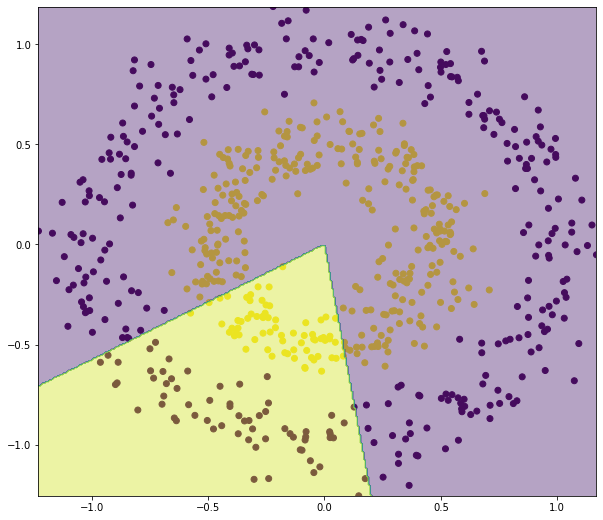

In [2381]:
X, y = make_circles(n_samples=700, noise=0.1, factor=0.5)
draw_decision_boundary(network, X, y)

In [2382]:
network.fit(X, y, criterion, epochs=500)

0) NN from scratch loss: 0.464151514445277                    
200) NN from scratch loss: 0.07392452041170024                    
400) NN from scratch loss: 0.0211653945484332                      


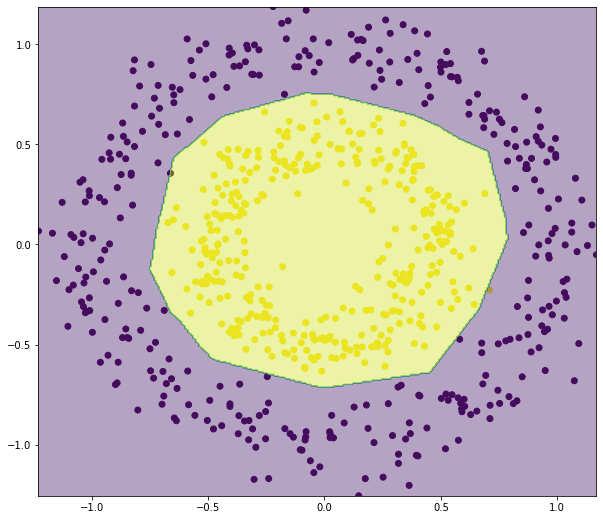

In [2383]:
draw_decision_boundary(network, X, y)